In [1]:
from tensorflow.keras.datasets import cifar10

from ctypes import CDLL, Structure, c_uint, c_float, c_ubyte, POINTER, pointer

import numpy as np
from termcolor import colored

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib notebook

In [2]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# conversion and preprocessing
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

In [9]:
# custom interface functions
lib = CDLL("./libdeep_cyber.so")

def unpackIndex(i, default):
    a = b = c = d = default
    if type(i) == int:
        d = i
    elif len(i) == 1:
        d = i[0]
    elif len(i) == 2:
        c = i[0]
        d = i[1]
    elif len(i) == 3:
        b = i[0]
        c = i[1]
        d = i[2]
    else:
        a = i[0]
        b = i[1]
        c = i[2]
        d = i[3]
    return (a, b, c, d)

class Tensor(Structure):
    _fields_ = [("a", c_uint),
               ("b", c_uint),
               ("c", c_uint),
               ("d", c_uint),
               ("data", POINTER(c_float))]

    def __init__(self, i):
        if type(i) == tuple:
            (a, b, c, d) = unpackIndex(i, 1)
            lib.create_tensor.argtypes = [c_uint, c_uint, c_uint, c_uint]
            lib.create_tensor.restype = Tensor
            t = lib.create_tensor(a, b, c, d)
            self.a = t.a
            self.b = t.b
            self.c = t.c
            self.d = t.d
            self.data = t.data
            t.data = None
        elif type(i) == np.ndarray:
            # create new tensor
            (a, b, c, d) = unpackIndex(i.shape, 1)
            lib.create_tensor.argtypes = [c_uint, c_uint, c_uint, c_uint]
            lib.create_tensor.restype = Tensor
            
            # copy data from numpy array
            t = lib.create_tensor(1, 1, 1, a*b*c*d)
            i = i.flatten()
            for x in range(t.d):
                t[x] = float(i[x])
                
            # move data 
            self.data = t.data
            t.data = None
            self.a = a
            self.b = b
            self.c = c
            self.d = d
        else:
            raise("Illegal input type!")

    def __del__(self):
        lib.free_tensor.argtypes = [Tensor]
        lib.free_tensor(self)

    def __getitem__(self, i):
        (a, b, c, d) = unpackIndex(i, 0)
        lib.at.argtypes = [POINTER(Tensor), c_uint, c_uint, c_uint, c_uint]
        lib.at.restype = POINTER(c_float)
        return lib.at(pointer(self), a, b, c, d)[0]

    def __setitem__(self, i, v):
        (a, b, c, d) = unpackIndex(i, 0)
        lib.at.argtypes = [POINTER(Tensor), c_uint, c_uint, c_uint, c_uint]
        lib.at.restype = POINTER(c_float)
        lib.at(pointer(self), a, b, c, d)[0] = float(v)

    @property
    def shape(self):
        if self.a != 1 and self.b != 1 and self.c != 1 and self.d != 1:
            return (self.a, self.b, self.c, self.d)
        elif self.b != 1 and self.c != 1 and self.d != 1:
            return (self.b, self.c, self.d)
        elif self.c != 1 and self.d != 1:
            return (self.c, self.d)
        else:
            return (self.d, )
        
    def reshape(self, i):
        (self.a, self.b, self.c, self.d) = unpackIndex(i, 1)
        
    def numpy(self):
        t = np.zeros((self.a, self.b, self.c, self.d))
        for ai in range(self.a):
            for bi in range(self.b):
                for ci in range(self.c):
                    for di in range(self.d):
                        t[ai, bi, ci, di] = self[ai, bi, ci, di]
        return t
    
def res_conv2d(X, w, b, kernel_size, strides, padding, groups):
    X = Tensor(X)
    w = Tensor(w)
    b = Tensor(b)
    lib.conv2d.argtypes = [Tensor, Tensor, Tensor, c_uint, c_uint, c_ubyte, c_uint]
    lib.conv2d.restype = Tensor
    return lib.conv2d(X, w, b, int(strides[0]), int(strides[1]), int(padding == "same"), int(groups)).numpy()

def res_dense(X, w, b):
    X = Tensor(X)
    w = Tensor(w)
    b = Tensor(b)
    lib.dense.argtypes = [Tensor, Tensor, Tensor]
    lib.dense.restype = Tensor
    return lib.dense(X, w, b).numpy()

def res_relu(X):
    X = Tensor(X)
    lib.relu.argtypes = [Tensor]
    lib.relu.restype = Tensor
    return lib.relu(X).numpy()

def res_sigmoid(X):
    X = Tensor(X)
    lib.sigmoid.argtypes = [Tensor]
    lib.sigmoid.restype = Tensor
    return lib.sigmoid(X).numpy()

def res_softmax(X):
    X = Tensor(X)
    lib.softmax.argtypes = [Tensor]
    lib.softmax.restype = Tensor
    return lib.softmax(X).numpy()

def res_maxpool2d(X, pool_sizes, strides, padding):
    X = Tensor(X)
    lib.maxpool2d.argtypes = [Tensor, c_uint, c_uint, c_uint, c_uint, c_ubyte]
    lib.maxpool2d.restype = Tensor
    return lib.maxpool2d(X, int(pool_sizes[0]), int(pool_sizes[1]), int(strides[0]), int(strides[1]), int(padding == "same")).numpy()

def res_avgpool2d(X, pool_sizes, strides, padding):
    X = Tensor(X)
    lib.avgpool2d.argtypes = [Tensor, c_uint, c_uint, c_uint, c_uint, c_ubyte]
    lib.avgpool2d.restype = Tensor
    return lib.avgpool2d(X, int(pool_sizes[0]), int(pool_sizes[1]), int(strides[0]), int(strides[1]), int(padding == "same")).numpy()

In [12]:
# build model
def run_model(X, c1, c2, c3, c4, d1, d2):
    X = res_conv2d(X, c1[0], c1[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_sizes=(2, 2), strides=(2, 2), padding="valid")

    X = res_conv2d(X, c2[0], c2[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_sizes=(2, 2), strides=(2, 2), padding="valid")

    X = res_conv2d(X, c3[0], c3[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_sizes=(2, 2), strides=(2, 2), padding="valid")

    X = res_conv2d(X, c4[0], c4[1], kernel_size=(3, 3), strides=(1, 1), padding="same", groups=1)
    X = res_relu(X)
    X = res_maxpool2d(X, pool_sizes=(2, 2), strides=(2, 2), padding="valid")

    X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
    X = res_dense(X, d1[0], d1[1])
    X = res_relu(X)
    X = res_dense(X, d2[0], d2[1])
    return res_softmax(X)

<IPython.core.display.Javascript object>


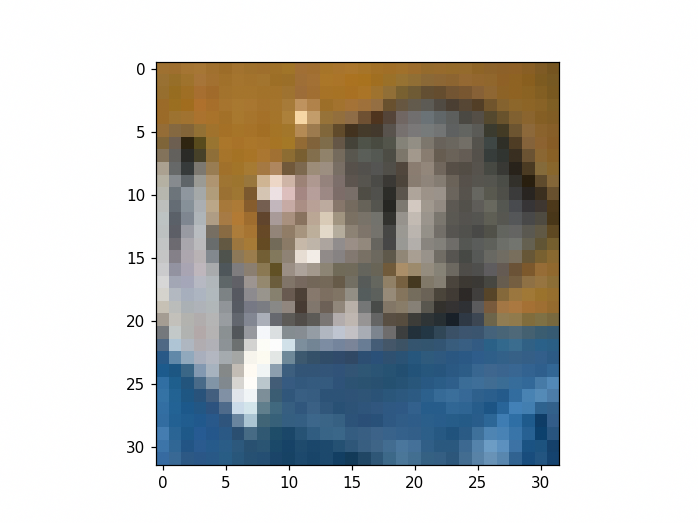

0 -- Reference: cat 	Result: dog


<IPython.core.display.Javascript object>


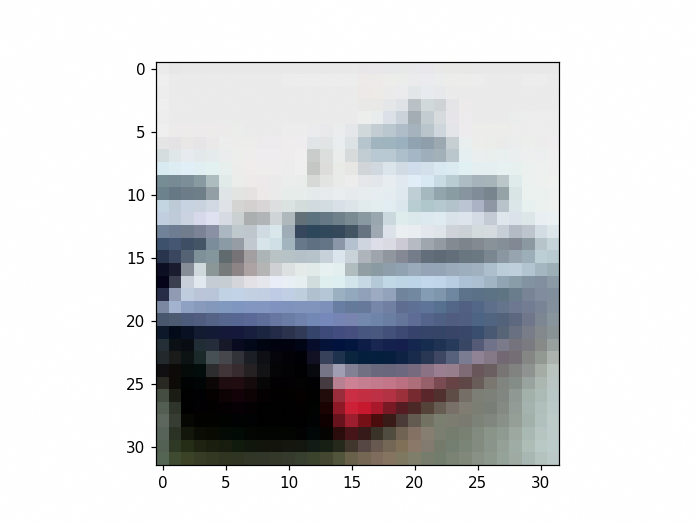

1 -- Reference: ship 	Result: ship


<IPython.core.display.Javascript object>


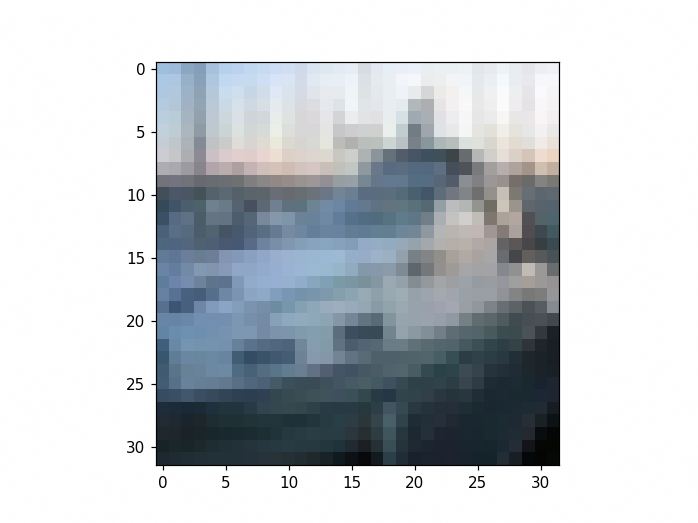

2 -- Reference: ship 	Result: ship


<IPython.core.display.Javascript object>


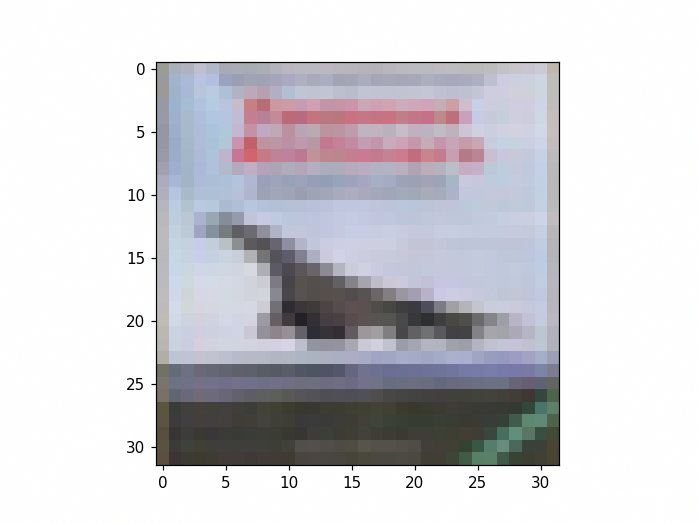

3 -- Reference: airplane 	Result: airplane


<IPython.core.display.Javascript object>


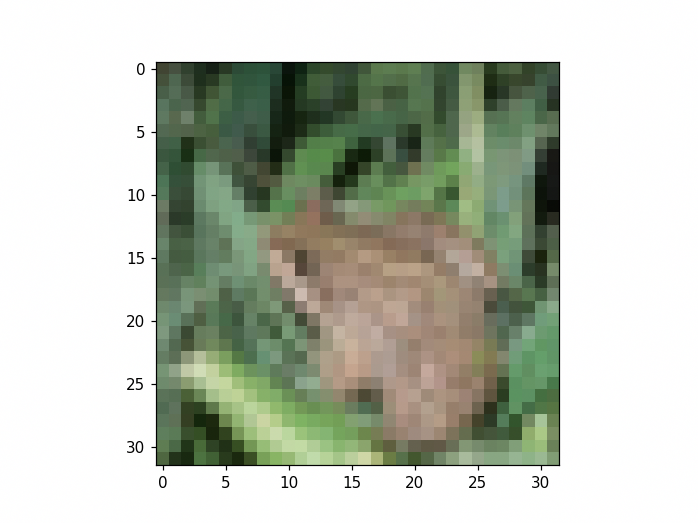

4 -- Reference: frog 	Result: frog


<IPython.core.display.Javascript object>


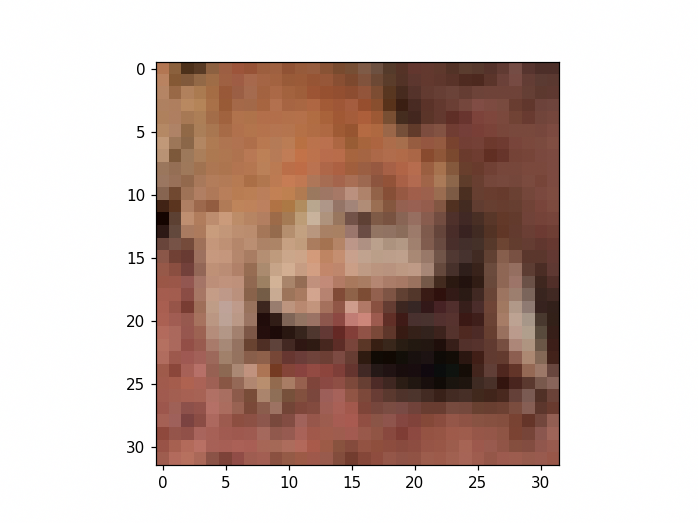

5 -- Reference: frog 	Result: frog


<IPython.core.display.Javascript object>


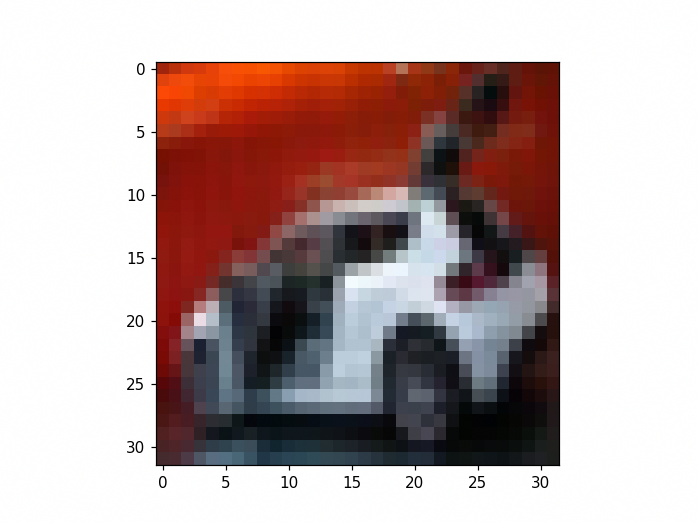

6 -- Reference: automobile 	Result: automobile


<IPython.core.display.Javascript object>


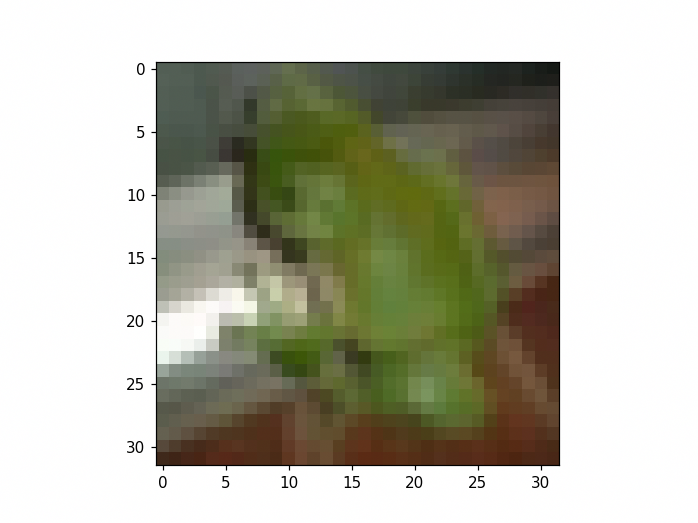

7 -- Reference: frog 	Result: frog


<IPython.core.display.Javascript object>


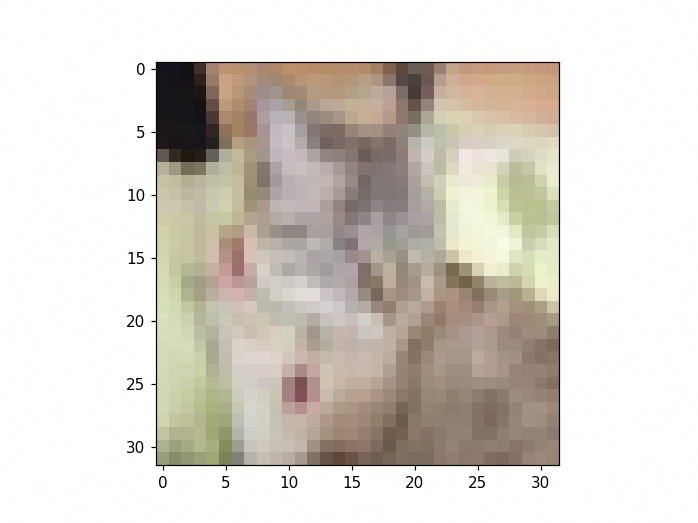

8 -- Reference: cat 	Result: cat


<IPython.core.display.Javascript object>


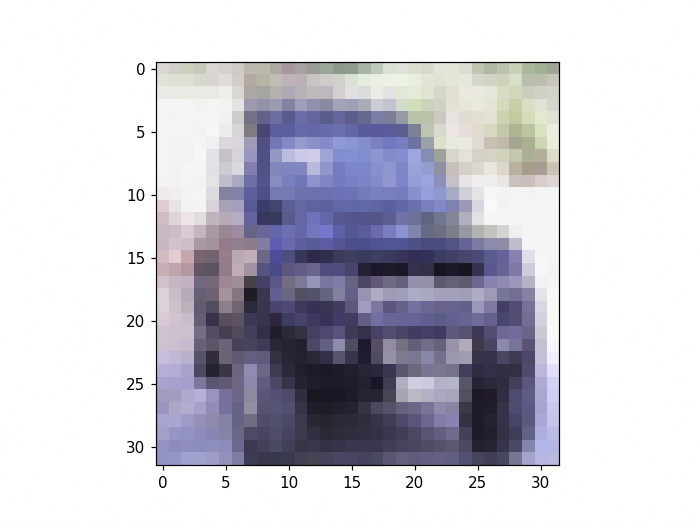

9 -- Reference: automobile 	Result: automobile


In [13]:
# execute model on test data
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

c1 = [np.load("c1w.npy"), np.load("c1b.npy")]
c2 = [np.load("c2w.npy"), np.load("c2b.npy")]
c3 = [np.load("c3w.npy"), np.load("c3b.npy")]
c4 = [np.load("c4w.npy"), np.load("c4b.npy")]
d1 = [np.load("d1w.npy"), np.load("d1b.npy")]
d2 = [np.load("d2w.npy"), np.load("d2b.npy")]

for i in range(10):
    plt.figure(i)
    plt.imshow(x_test[i])
    plt.show()
    
    res = run_model(np.array([x_test[i]]), c1, c2, c3, c4, d1, d2)
    
    color = "green"
    if int(y_test[i]) != np.argmax(res):
        color = "red"
    
    print(i, "-- Reference:", classes[int(y_test[i])], colored("\tResult: " + classes[np.argmax(res)], color))